In [6]:
import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
from utils.helpers import pickle_load, pickle_save
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878'
color2 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

# Data

### Planck

In [7]:
from experiments.planck.model import planck_theory, PlanckLitePy
from experiments.planck.params import PCosmology
from configs.Planckconfig import get_config as config_planck

In [8]:
cfg_planck = config_planck('planck')
planck_likelihood = PlanckLitePy(
    data_directory=cfg_planck.path.data,
    year=cfg_planck.planck.year,
    spectra=cfg_planck.planck.spectra,
    use_low_ell_bins=cfg_planck.planck.use_low_ell_bins,
)
parameters = cfg_planck.sampling.mean
params = PCosmology(ombh2=parameters[0], omch2=parameters[1], h = parameters[2], ln_10_10_As=parameters[3], ns=parameters[4])
theory = planck_theory(params, cfg_planck)

INFO:plite.py.__init__():198      Shape of data is (615,)


In [9]:
bval, X_data, X_sig = np.genfromtxt(planck_likelihood.like_file, unpack=True)

idx = np.where(bval == 32.)[0]
l1 = bval[idx[0]:idx[1]]
l2 = bval[idx[1]:idx[2]]
l3 = bval[idx[2]:]

cl1 = X_data[idx[0]:idx[1]]
cl2 = X_data[idx[1]:idx[2]]
cl3 = X_data[idx[2]:]

s1 = X_sig[idx[0]:idx[1]]
s2 = X_sig[idx[1]:idx[2]]
s3 = X_sig[idx[2]:]

f1 = l1 * (l1 +1) / (2.0 * np.pi)
f2 = l2 * (l2 +1) / (2.0 * np.pi)
f3 = l3 * (l3 +1) / (2.0 * np.pi)

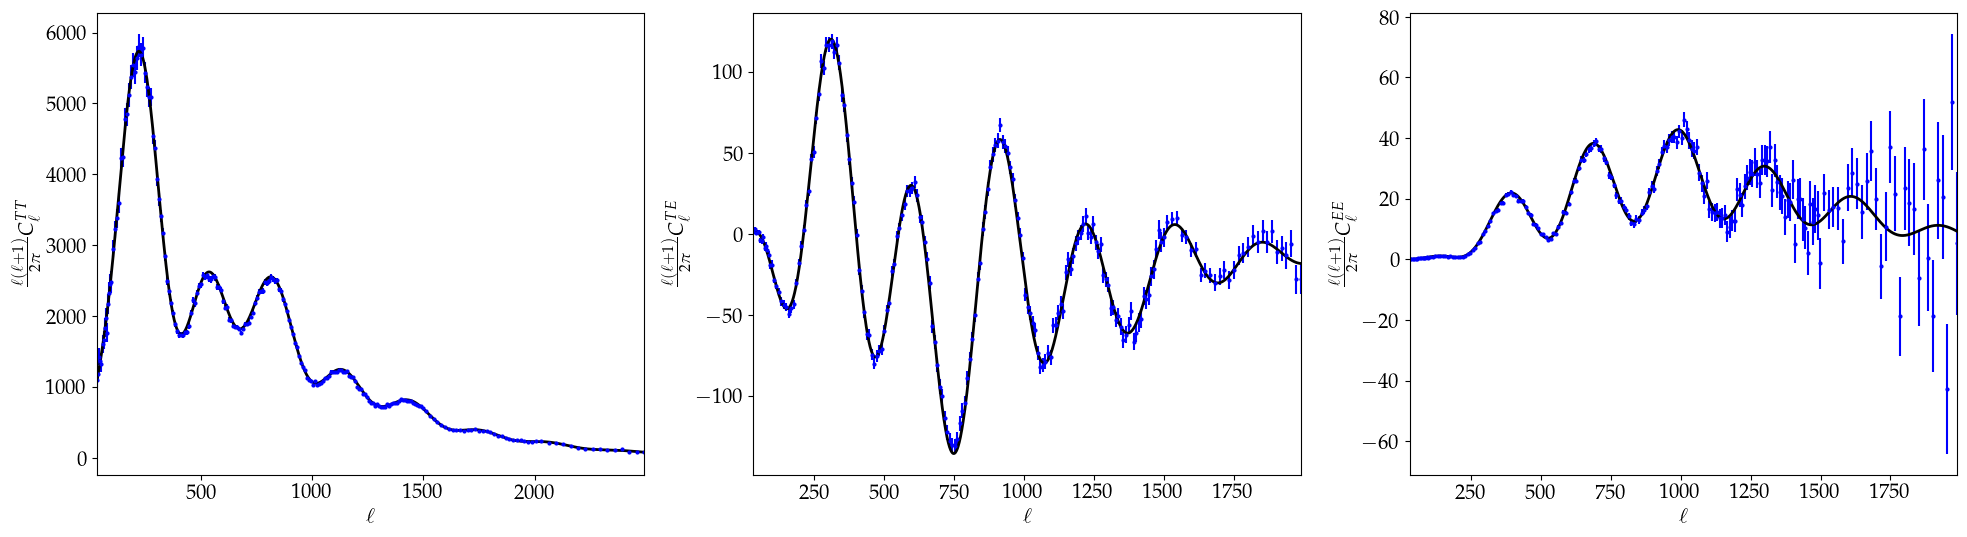

In [10]:
plt.figure(figsize = (24, 6))
plt.subplot(131)
plt.errorbar(l1, f1*cl1, yerr=f1*s1, fmt = 'bo', markersize=2)
plt.plot(theory['ells'], theory['tt'], lw = 2, c = 'k')
plt.xlim(min(l1), max(l1))
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}^{TT}$', fontsize = fontSize)
plt.xlabel(r'$\ell$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(132)
plt.errorbar(l2, f2*cl2, yerr=f2*s2, fmt = 'bo', markersize=2)
plt.plot(theory['ells'], theory['te'], lw = 2, c = 'k')
plt.xlim(min(l2), max(l2))
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}^{TE}$', fontsize = fontSize)
plt.xlabel(r'$\ell$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(133)
plt.errorbar(l3, f3*cl3, yerr=f3*s3, fmt = 'bo', markersize=2)
plt.plot(theory['ells'], theory['ee'], lw = 2, c = 'k')
plt.xlim(min(l3), max(l3))
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_{\ell}^{EE}$', fontsize = fontSize)
plt.xlabel(r'$\ell$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

In [11]:
planck_cov = np.linalg.inv(planck_likelihood.fisher)

In [12]:
Nele   = planck_cov.shape[0]
newCov = np.zeros((Nele, Nele))

for i in range(Nele):
	for j in range(Nele):
		newCov[i,j] = planck_cov[i,j]/np.sqrt(planck_cov[i,i]*planck_cov[j,j])

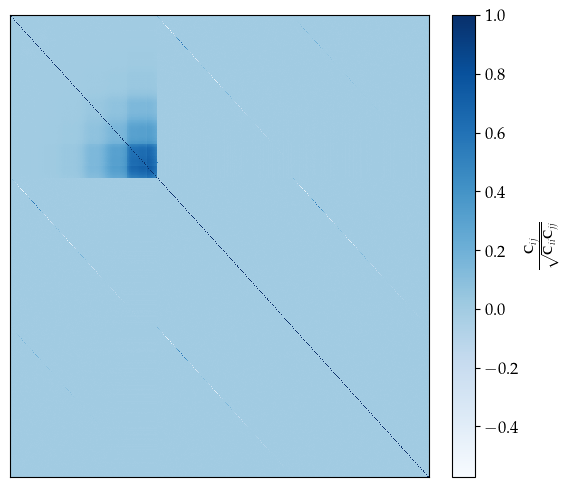

In [13]:
fig, ax = plt.subplots(figsize = (6,6))
heatmap = ax.pcolor(newCov, cmap=plt.cm.Blues)
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=12)
cbar.ax.tick_params(labelsize=12) 
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()
ax.xaxis.tick_top()
# plt.savefig('/Users/Harry/Desktop/kids_covariance.pdf', bbox_inches='tight')
plt.show()

### JLA

In [14]:
from experiments.jla.jlalite import JLALitePy
from experiments.jla.params import Cosmology
from configs.JLAconfig import get_config as config_jla

In [15]:
cfg_jla = config_jla('jla')
parameter = Cosmology(ombh2=0.022, omch2=0.1439, h = 0.7248)

jla_like = JLALitePy(cfg_jla)
bestfit = jla_like.theory(parameter)

INFO:jlalite.py.marginalise_nuisance():267      Quick marginalising over nuisance parameters


In [16]:
redshifts = jla_like.inputs['z']
idx = np.argsort(redshifts)
minz = min(redshifts)
maxz = max(redshifts)
gridz = np.linspace(minz, maxz, 1000)
gridbestfit = np.interp(gridz, redshifts[idx], bestfit[idx])

In [17]:
sigma = np.sqrt(np.diag(jla_like.newcov))

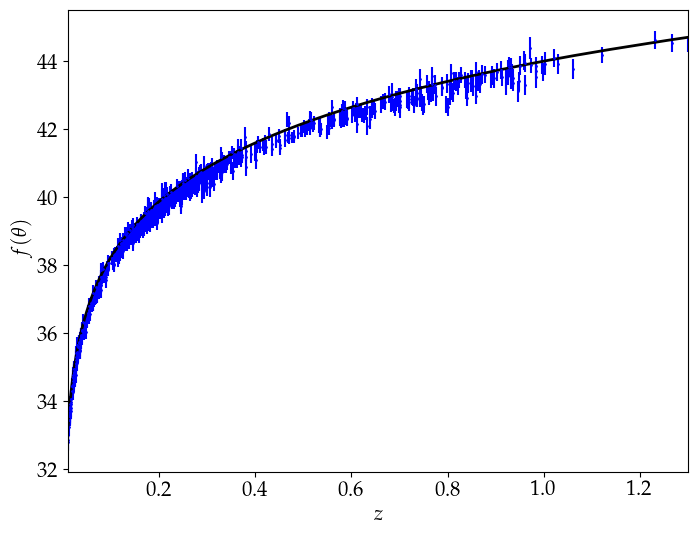

In [18]:
plt.figure(figsize=(8,6))
plt.errorbar(redshifts, jla_like.newdata, yerr = sigma, fmt = 'bo', ms = 1)
plt.plot(gridz, gridbestfit, lw =2, c='k')
plt.ylabel(r'$f(\theta)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(minz, maxz)
plt.show()

In [19]:
Nele   = jla_like.newcov.shape[0]
newCov_jla = np.zeros((Nele, Nele))

for i in range(Nele):
	for j in range(Nele):
		newCov_jla[i,j] = jla_like.newcov[i,j]/np.sqrt(jla_like.newcov[i,i]*jla_like.newcov[j,j])

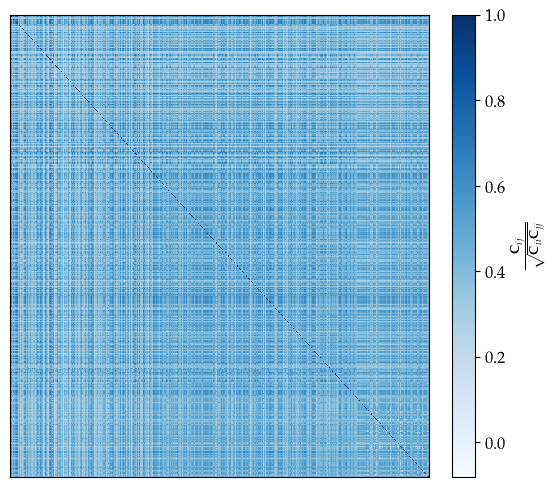

In [20]:
fig, ax = plt.subplots(figsize = (6,6))
heatmap = ax.pcolor(newCov_jla, cmap=plt.cm.Blues)
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=12)
cbar.ax.tick_params(labelsize=12) 
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()
ax.xaxis.tick_top()
# plt.savefig('/Users/Harry/Desktop/kids_covariance.pdf', bbox_inches='tight')
plt.show()

# Planck Analysis

In [21]:
camb_1 = pickle_load('src/emulike/planck/samples', 'samples_lcdm_CAMB_experiment_1')  
camb_2 = pickle_load('src/emulike/planck/samples', 'samples_lcdm_CAMB_experiment_2')  
camb_samples_1 = camb_1.get_chain(flat=True, thin = 2, discard = 1000)
camb_samples_2 = camb_2.get_chain(flat=True, thin = 2, discard = 1000)

In [22]:
# gp_1 = pickle_load('src/emulike/planck/samples', 'samples_lcdm_GP_1500_experiment_1')
# gp_2 = pickle_load('src/emulike/planck/samples', 'samples_lcdm_GP_1500_experiment_2')

gp_1 = pickle_load('src/emulike/jointanalysis/samples', 'samples_lcdm_emulator_experiment_1')
gp_2 = pickle_load('src/emulike/jointanalysis/samples', 'samples_lcdm_emulator_experiment_2')

gp_samples_1 = gp_1.get_chain(flat=True, thin = 2, discard = 1000)
gp_samples_2 = gp_2.get_chain(flat=True, thin = 2, discard = 1000)

In [23]:
NDIM = camb_samples_1.shape[1]
names = ["x%s"%i for i in range(NDIM)]
labels = [r'$\Omega_{b}h^{2}$', 
          r'$\Omega_{cdm}h^{2}$', 
          r'$h$', 
          r'$ln(10^{10}A_{s})$', 
          r'$n_{s}$']

samples_1 = MCSamples(samples=camb_samples_1,names = names, labels = labels, settings = settings, label = 'CAMB')
samples_2 = MCSamples(samples=gp_samples_1,names = names, labels = labels, settings = settings, label = 'Emulator')

Removed no burn in
Removed no burn in


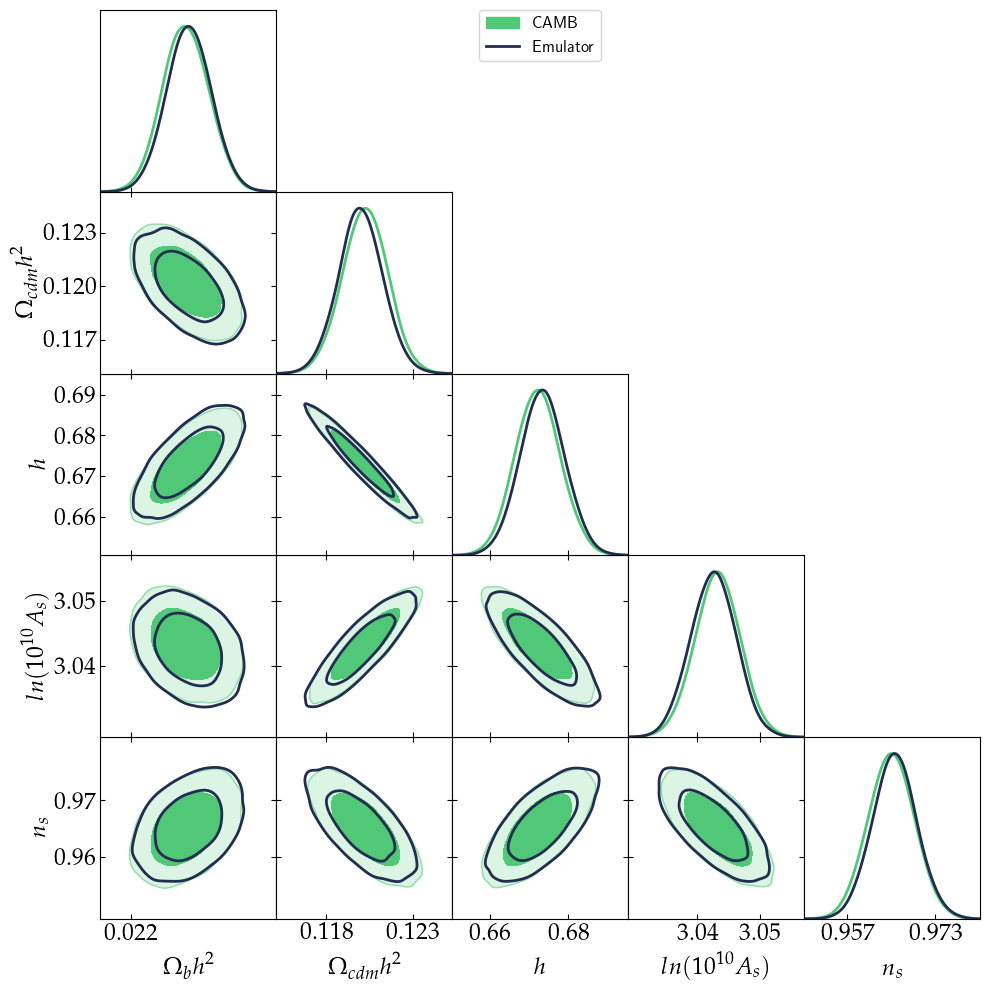

In [24]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True, False], contour_colors=[color1, color2], contour_lws=[2,2], contour_ls=['-','-'])
# plt.savefig('plots/triangle_plot_uniform_accurate.pdf', transparent = False, bbox_inches = 'tight') 
# plt.savefig('plots/triangle_plot_uniform_accurate.png', transparent = False, bbox_inches = 'tight') 
plt.show()

# JLA Analysis

In [21]:
sim_jla_1 = pickle_load('src/emulike/jla/samples', 'samples_lcdm_Analytic_experiment_1')
sim_jla_2 = pickle_load('src/emulike/jla/samples', 'samples_lcdm_Analytic_experiment_2')

gp_jla_1 = pickle_load('src/emulike/jla/samples', 'samples_lcdm_GP_700_experiment_1')
gp_jla_2 = pickle_load('src/emulike/jla/samples', 'samples_lcdm_GP_700_experiment_2')


sim_jla_samples_1 = sim_jla_1.get_chain(flat=True, thin = 2, discard = 1000)
sim_jla_samples_2 = sim_jla_2.get_chain(flat=True, thin = 2, discard = 1000)

gp_jla_samples_1 = gp_jla_1.get_chain(flat=True, thin = 2, discard = 1000)
gp_jla_samples_2 = gp_jla_2.get_chain(flat=True, thin = 2, discard = 1000)

In [22]:
NDIM = sim_jla_samples_1.shape[1]
names = ["x%s"%i for i in range(NDIM)]
labels = [r'$\Omega_{b}h^{2}$', 
          r'$\Omega_{cdm}h^{2}$', 
          r'$h$']

samples_1 = MCSamples(samples=sim_jla_samples_1,names = names, labels = labels, settings = settings, label = 'Analytic')
samples_2 = MCSamples(samples=gp_jla_samples_1,names = names, labels = labels, settings = settings, label = 'Emulator')

Removed no burn in
Removed no burn in


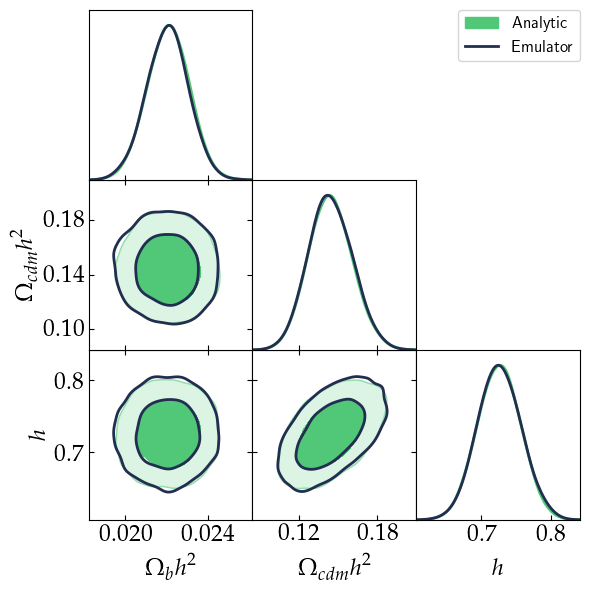

In [23]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True, False], contour_colors=[color1, color2], contour_lws=[2,2], contour_ls=['-','-'])
# plt.savefig('plots/triangle_plot_uniform_accurate.pdf', transparent = False, bbox_inches = 'tight') 
# plt.savefig('plots/triangle_plot_uniform_accurate.png', transparent = False, bbox_inches = 'tight') 
plt.show()

# Accuracy

In [24]:
planck_lcdm = pickle_load('src/emulike/planck/accuracies/', 'acc_lcdm_1500')
planck_lcdm_df = pd.DataFrame(planck_lcdm*100, columns = ['Accuracy'])

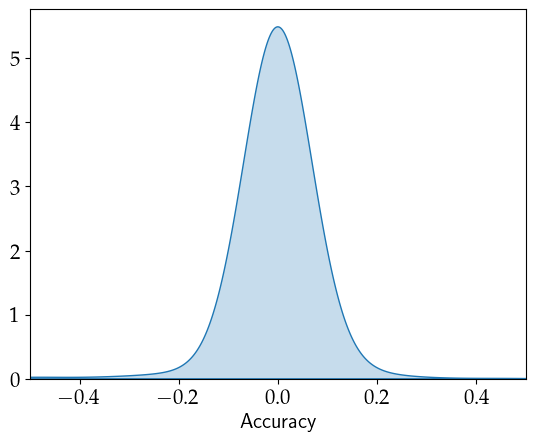

In [25]:
sns.kdeplot(data=planck_lcdm_df, x="Accuracy", bw_method = 1.0, fill=True, gridsize=2000)
plt.xlabel(r'Accuracy', fontsize = fontSize)
plt.ylabel('', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-0.5, 0.5)
plt.show()

In [26]:
jla_lcdm = pickle_load('src/emulike/jla/accuracies/', 'acc_lcdm_700')
jla_lcdm_df = pd.DataFrame(jla_lcdm*100*1000, columns = ['Accuracy'])

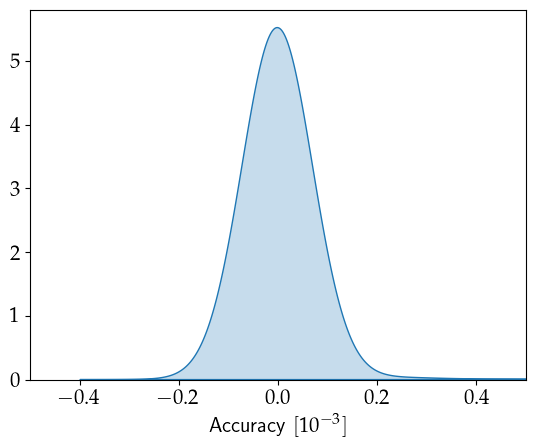

In [27]:
sns.kdeplot(data=jla_lcdm_df, x="Accuracy", bw_method = 1.0, fill=True, gridsize=2000)
plt.xlabel(r'Accuracy $[10^{-3}]$', fontsize = fontSize)
plt.ylabel('', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-0.5, 0.5)
plt.show()

# Metrics

In [1]:
from configs.Planckconfig import get_config as config_planck
from configs.JLAconfig import get_config as config_jla
from utils.metrics import emcee_stats

### Emulator

In [2]:
fname1 = 'src/emulike/planck/samples/samples_lcdm_GP_1500_experiment_1'
fname2 = 'src/emulike/planck/samples/samples_lcdm_GP_1500_experiment_2'
cfg_planck = config_planck('planck')

In [3]:
emcee_stats(cfg_planck, fname1, fname2)

Number of samples for chain 1: 100000
Number of samples for chain 2: 100000
Number of samples for chain 1 (after processing): 45000
Number of samples for chain 2 (after processing): 45000


,r_hat,n_eff,mean,std,scaled_n_eff
ombh2,1.0006,93266.9703,0.0223,0.0001,0.466335
omch2,1.0006,88707.6653,0.1203,0.0013,0.443538
h,1.0004,90334.4236,0.6720,0.0057,0.451672
As,1.0010,87657.0100,3.0433,0.0036,0.438285
ns,1.0017,88189.7595,0.9649,0.0041,0.440949


In [4]:
fname1 = 'src/emulike/jointanalysis/samples/samples_lcdm_emulator_experiment_1'
fname2 = 'src/emulike/jointanalysis/samples/samples_lcdm_emulator_experiment_2'
cfg_planck = config_planck('planck')

In [5]:
emcee_stats(cfg_planck, fname1, fname2)

Number of samples for chain 1: 100000
Number of samples for chain 2: 100000
Number of samples for chain 1 (after processing): 45000
Number of samples for chain 2 (after processing): 45000


,r_hat,n_eff,mean,std,scaled_n_eff
ombh2,1.0012,93224.3237,0.0224,0.0002,0.466122
omch2,1.0035,93230.1424,0.1199,0.0015,0.466151
h,1.0031,94057.8448,0.6738,0.0063,0.470289
As,1.0000,89305.9336,3.0426,0.0044,0.446530
ns,1.0012,87944.2447,0.9655,0.0043,0.439721


In [31]:
fname1 = 'src/emulike/jla/samples/samples_lcdm_GP_700_experiment_1'
fname2 = 'src/emulike/jla/samples/samples_lcdm_GP_700_experiment_2'
cfg_jla = config_jla('jla')

In [32]:
emcee_stats(cfg_jla, fname1, fname2)

Number of samples for chain 1: 60000
Number of samples for chain 2: 60000
Number of samples for chain 1 (after processing): 27000
Number of samples for chain 2 (after processing): 27000


,r_hat,n_eff,mean,std,scaled_n_eff
ombh2,1.0001,53624.2468,0.0220,0.0010,0.446869
omch2,1.0018,50860.7401,0.1439,0.0163,0.423840
h,1.0026,53484.8136,0.7248,0.0305,0.445707


### Simulator

In [33]:
fname1 = 'src/emulike/jla/samples/samples_lcdm_Analytic_experiment_1'
fname2 = 'src/emulike/jla/samples/samples_lcdm_Analytic_experiment_2'

In [34]:
emcee_stats(cfg_jla, fname1, fname2)

Number of samples for chain 1: 60000
Number of samples for chain 2: 60000
Number of samples for chain 1 (after processing): 27000
Number of samples for chain 2 (after processing): 27000


,r_hat,n_eff,mean,std,scaled_n_eff
ombh2,1.0004,54986.9177,0.0221,0.0010,0.458224
omch2,1.0018,51368.2679,0.1437,0.0162,0.428069
h,1.0009,53101.0736,0.7246,0.0300,0.442509


# MCEvidence

In [35]:
from utils.metrics import calculate_evidence

### Emulator

In [38]:
fname1 = 'src/emulike/jla/samples/samples_lcdm_GP_700_experiment_1'
fname2 = 'src/emulike/jla/samples/samples_lcdm_GP_700_experiment_2'

In [39]:
calculate_evidence(cfg_jla, fname1, fname2)

354.3637101424611

In [40]:
fname1 = 'src/emulike/planck/samples/samples_lcdm_GP_1500_experiment_1'
fname2 = 'src/emulike/planck/samples/samples_lcdm_GP_1500_experiment_2'

In [41]:
calculate_evidence(cfg_planck, fname1, fname2)

262.303573494526

### Simulator

In [36]:
fname1 = 'src/emulike/jla/samples/samples_lcdm_Analytic_experiment_1'
fname2 = 'src/emulike/jla/samples/samples_lcdm_Analytic_experiment_2'

In [37]:
calculate_evidence(cfg_jla, fname1, fname2)

353.9251999744784

In [47]:
fname1 = 'src/emulike/planck/samples/samples_lcdm_CAMB_experiment_1'
fname2 = 'src/emulike/planck/samples/samples_lcdm_CAMB_experiment_2'

In [48]:
calculate_evidence(cfg_planck, fname1, fname2)

262.8327439228374